In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
df=pd.read_csv("train.csv")
df_original=df

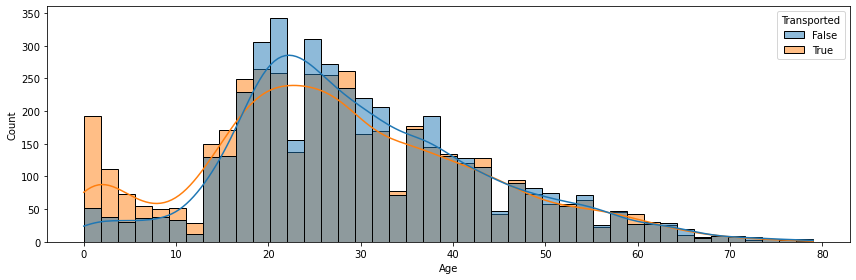

In [22]:
plt.figure(figsize=(12,4))
sns.histplot(data=df,x="Age",hue="Transported",kde=True)
plt.tight_layout()
#There seems to be a correlation between age and chance of 
#being transported, at least until age ~25

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

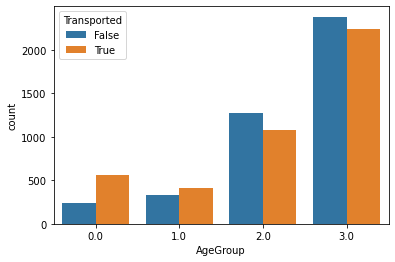

In [23]:
#We'll create a new category to classify if a passenger is child, 
#adolescent, young adult or older
df.loc[df["Age"]<=12,"AgeGroup"]=0
df.loc[(df["Age"]>12) & (df["Age"]<18), "AgeGroup"]=1
df.loc[(df["Age"]>=18) & (df["Age"]<=25), "AgeGroup"]=2
df.loc[df["Age"]>25, "AgeGroup"]=3
sns.countplot(data=df,x="AgeGroup",hue="Transported")
plt.tight_layout

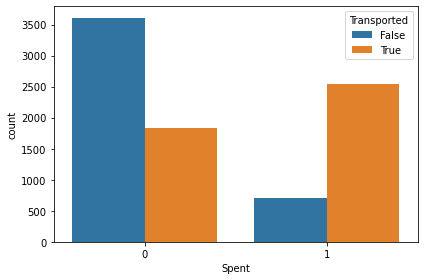

In [24]:
#Create new columns for the sum of expenses 
#and a boolean value for their general spending practices
df["Expenses"]=(df.RoomService+df.FoodCourt+df.ShoppingMall+df.Spa+df.VRDeck)
df["Spent"]=(df["Expenses"]==0).astype(int)
sns.countplot(data=df,x="Spent",hue="Transported")
plt.tight_layout()


AxesSubplot(0.125,0.71587;0.775x0.16413)
AxesSubplot(0.125,0.518913;0.775x0.16413)
AxesSubplot(0.125,0.321957;0.775x0.16413)
AxesSubplot(0.125,0.125;0.775x0.16413)


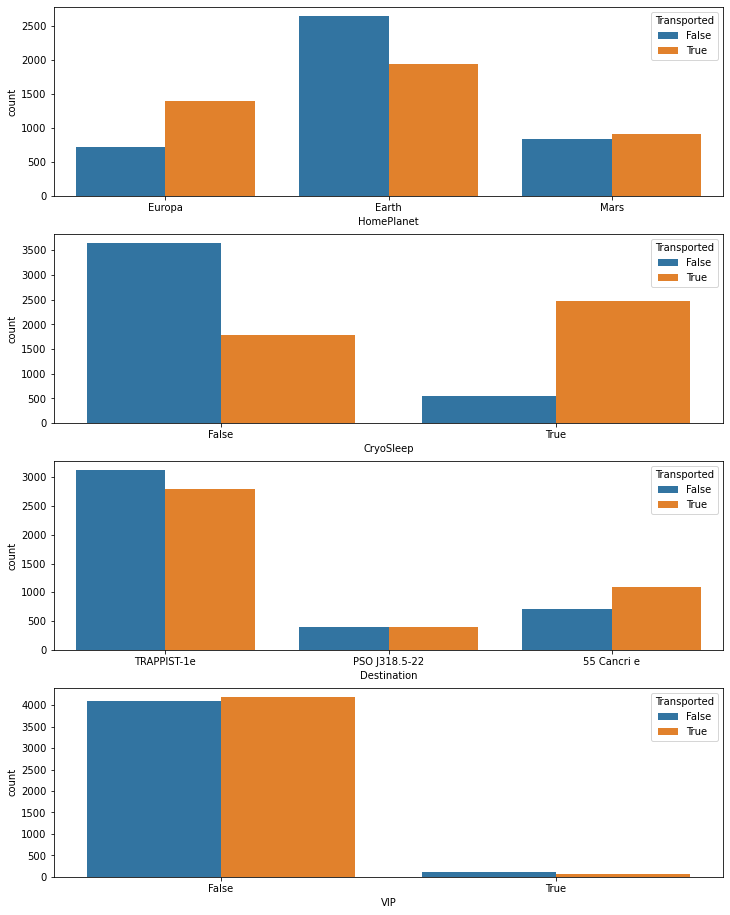

In [25]:
bin_cat=["HomePlanet","CryoSleep","Destination","VIP"]
fig=plt.figure(figsize=(12,16))
for i,j in enumerate(bin_cat):
    ax=fig.add_subplot(4,1,1+i)
    print(sns.countplot(data=df,x=j,axes=ax,hue="Transported"))
#CryoSleep is an interesting indicator
#VIP not that much

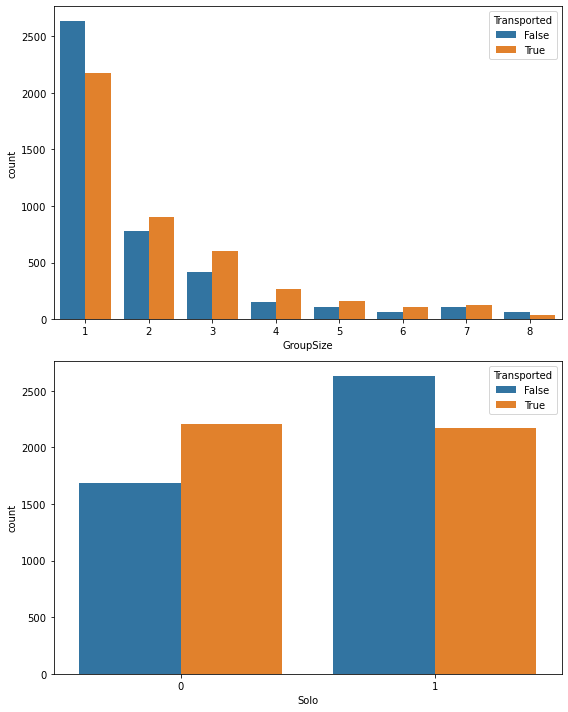

In [26]:
#From passenger ID we can extract group ID and group size
df["Group"]=df["PassengerId"].apply(lambda x: x.split("_")[0]).astype(int)
df["GroupSize"]=df["Group"].map(lambda x: pd.concat([df["Group"]]).value_counts()[x])
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
sns.countplot(data=df,x="GroupSize",hue="Transported")
fig.tight_layout()
#We see that solo passengers have less chance of being transported than anyone less
#For that we'll create a boolean column for solo passengers reference
df["Solo"]=(df["GroupSize"]==1).astype(int)
plt.subplot(2,1,2)
sns.countplot(data=df,x="Solo",hue="Transported")
plt.tight_layout()

In [27]:
#We want to get the information about deck, number and side from the Cabin column
df["Cabin"].fillna("X/9999/X",inplace=True)
#Get rid of the NaN values so we can work with the rest
df["Deck"]=df["Cabin"].apply(lambda x: x.split("/")[0])
df["CabinNo"]=df["Cabin"].apply(lambda x: x.split("/")[1]).astype(int)
df["Side"]=df["Cabin"].apply(lambda x: x.split("/")[2])
#Return the NaN values and get rid of the Cabin column
df.loc[df["Deck"]=="X","Deck"]=np.nan
df.loc[df["CabinNo"]==9999,"CabinNo"]=np.nan
df.loc[df["Side"]=="X","Side"]=np.nan
df=df.drop("Cabin",axis=1)
#We have an outlier on Deck column, 5 instances of value "T"

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

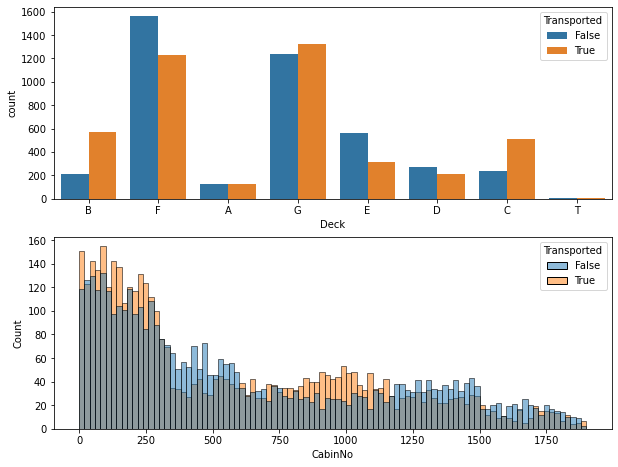

In [28]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=df,x="Deck",hue="Transported")
plt.subplot(3,1,2)
sns.histplot(data=df,x="CabinNo",hue="Transported",binwidth=20)
plt.tight_layout
#In the Cabin number graph, we see that groups of 300, starting from 0
#behave similarly. Thus we will group them in categories based on their number

<AxesSubplot:xlabel='CabinPlace', ylabel='count'>

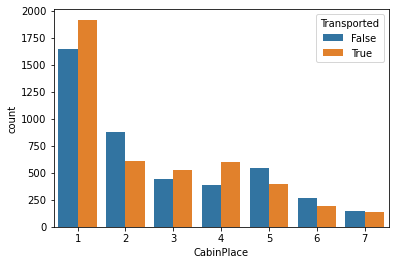

In [29]:
def cabin_bin(i):
    no=i["CabinNo"]
    if no<300: return 1
    elif no<600: return 2
    elif no<900: return 3
    elif no<1200: return 4
    elif no<1500: return 5
    elif no<1800: return 6
    else:return 7
df["CabinPlace"]=df.apply(lambda x:cabin_bin(x), axis=1)
sns.countplot(data=df,x="CabinPlace",hue="Transported")

<AxesSubplot:xlabel='FamSize', ylabel='count'>

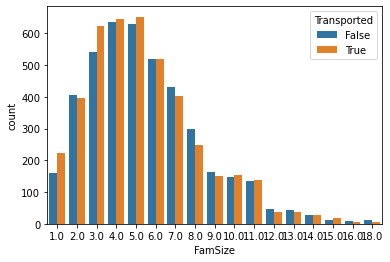

In [30]:
#We want to extract the surnames from their names to calculate family size
#Fill the NaN values so we can do that
df["Name"].fillna("X X",inplace=True)
df["Surname"]=df["Name"].str.split().str[-1]
df["FamSize"]=df["Surname"].map(lambda x: pd.concat([df["Surname"]]).value_counts()[x])
#And return the NaN values
df.loc[df["Surname"]=="X","Surname"]=np.nan
df.loc[df["FamSize"]>50,"FamSize"]=np.nan
df=df.drop("Name",axis=1)
sns.countplot(data=df,x="FamSize",hue="Transported")

<AxesSubplot:ylabel='count'>

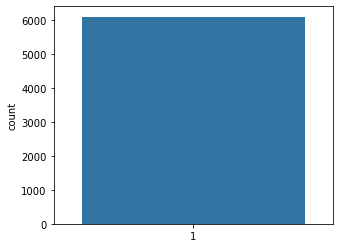

In [31]:
group_planet=df.groupby(["Group","HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
plt.figure(figsize=(5,4))
sns.countplot(x=((group_planet>0)).sum(axis=1))
#Members of the same group are from the same home planet

<AxesSubplot:ylabel='count'>

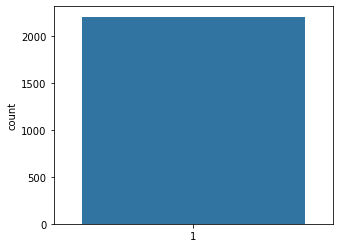

In [32]:
surname_planet=df.groupby(["Surname","HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
plt.figure(figsize=(5,4))
sns.countplot(x=(surname_planet>0).sum(axis=1))
#Members of the same family are from the same home planet

<AxesSubplot:xlabel='Deck', ylabel='HomePlanet'>

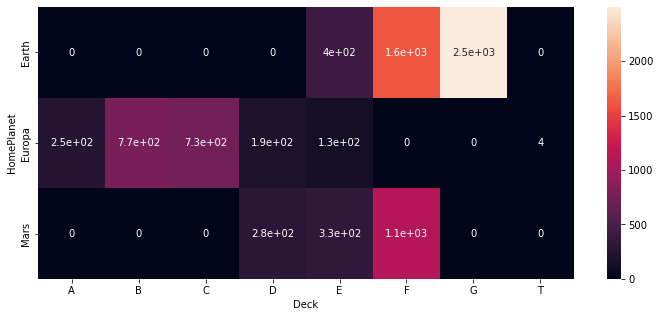

In [33]:
deck_planet=df.groupby(["Deck","HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
plt.figure(figsize=(12,5))
sns.heatmap(deck_planet.T,annot=True)
#Decks ABC have exclusively Europans, deck G has Earthers and decks DEF
#have passengers from multiple planets

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

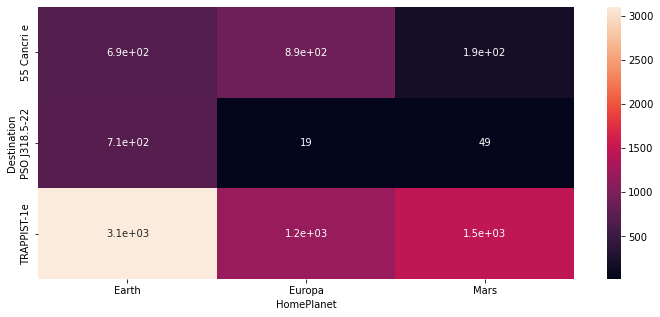

In [34]:
planet_destination=df.groupby(["HomePlanet","Destination"])["Destination"].size().unstack().fillna(0)
plt.figure(figsize=(12,5))
sns.heatmap(planet_destination.T,annot=True)
#Most travellers to Trappist are from Earth

Now that we have some relation between known values and missing ones
it is time we try to fill them

In [35]:
#Replace NaN home planet if said passenger belongs in a group with known home planet
group_planet_idx=df[df["HomePlanet"].isna()][(df[df["HomePlanet"].isna()]["Group"]).isin(group_planet.index)].index
df.loc[group_planet_idx,"HomePlanet"]=df.iloc[group_planet_idx,:]["Group"].map(lambda x: group_planet.idxmax(axis=1)[x])
#Replace NaN home planet if said passenger belongs to planet-exclusive decks
df.loc[(df["HomePlanet"].isna()) & (df["Deck"].isin(["A","B","C","T"])),"HomePlanet"]="Europa"
df.loc[(df["HomePlanet"].isna() & (df["Deck"]=="G")),"HomePlanet"]="Earth"
#Replace NaN home planet if said passenger has a family with known home planet
surname_planet_idx=df[df["HomePlanet"].isna()][(df[df["HomePlanet"].isna()]["Surname"]).isin(surname_planet.index)].index
df.loc[surname_planet_idx,"HomePlanet"]=df.iloc[surname_planet_idx,:]["Surname"].map(lambda x: surname_planet.idxmax(axis=1)[x])
#Still 10 NaN home planet remaining. All 10 are headed to Trappist, so we assign them to Earth,
#except if they stay on deck D, where they'll be assigned to Mars
df.loc[(df["HomePlanet"].isna()) & ~(df["Deck"]=="D"),"HomePlanet"]="Earth"
df.loc[(df["HomePlanet"].isna()) & (df["Deck"]=="D"),"HomePlanet"]="Mars"

In [36]:
#The majority (69.5%) of the passengers are heading towards Trappist,
#so we'll input that value in place of the missing ones
df.loc[(df["Destination"].isna()),"Destination"]="TRAPPIST-1e"

C:\Users\giorg\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


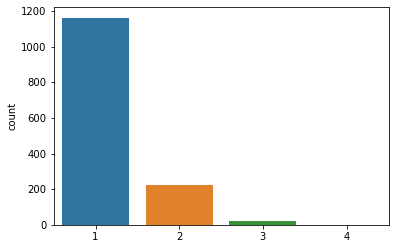

In [37]:
surname_group=df[df["GroupSize"]>1].groupby(["Group","Surname"])["Surname"].size().unstack().fillna(0)
sns.countplot(((surname_group>0)).sum(axis=1))
surname_group_idx=df[df["Surname"].isna()][(df[df["Surname"].isna()]["Group"]).isin(surname_group.index)].index
df.loc[surname_group_idx,"Surname"]=df.iloc[surname_group_idx,:]["Group"].map(lambda x: surname_group.idxmax(axis=1)[x])

In [38]:
#With the new surnames, we can update FamSize column
df["Surname"].fillna("X",inplace=True)
df["FamSize"]=df["Surname"].map(lambda x: pd.concat([df["Surname"]]).value_counts()[x])
#And return the NaN values
df.loc[df["Surname"]=="X","Surname"]=np.nan
df.loc[df["FamSize"]>50,"FamSize"]=np.nan
df=df.drop("Surname",axis=1)

In [39]:
df.groupby(["HomePlanet","Solo","AgeGroup"])["Expenses"].mean().unstack().fillna(0)


AgeGroup         0.0          1.0          2.0          3.0
HomePlanet Solo                                            
Earth      0     0.0   777.896825   798.155116   816.008602
           1     0.0   649.072100   794.524932   825.332025
Europa     0     0.0  1108.509615  2760.727273  3963.897802
           1     0.0     0.000000  2551.644737  3971.775862
Mars       0     0.0  1231.292308  1211.517949  1187.901809
           1     0.0  1930.710526  1198.976852  1130.813333

In [40]:
#TODO
#check correlation between deck/side and group
#check family and group
#fill empty cryosleep values depending on spending